<a href="https://colab.research.google.com/github/sujalambatkar/NLPproject/blob/main/NLP_TASK_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Data Loading**

In [ ]:
import pandas as pd

# Load your dataset
data = pd.read_excel("/content/final dataset for nlp.xlsx")

# Check the dataset
print("Dataset Shape:", data.shape)
print(data.columns)
data.head()


Dataset Shape: (997, 3)
Index(['ID', 'Text', 'Label'], dtype='object')


,ID,Text,Label
0,1,Space exploration is entering a new era. Exper...,Non-Plagiarized
1,2,transformed in has Advancements extensively On...,Plagiarized
2,3,Renewable energy sources are vital for sustain...,Non-Plagiarized
3,7,Renewable energy sources are vital for sustain...,Non-Plagiarized
4,8,Climate change poses a significant threat to h...,Non-Plagiarized


# **2. Text Preprocessing**

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Clean the text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply to the 'Text' column
data['cleaned_text'] = data['Text'].apply(clean_text)

data[['Text', 'cleaned_text']].head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Text,cleaned_text
0,Space exploration is entering a new era. Exper...,space exploration entering new era experts sug...
1,transformed in has Advancements extensively On...,transformed advancements extensively ongoing o...
2,Renewable energy sources are vital for sustain...,renewable energy sources vital sustainability ...
3,Renewable energy sources are vital for sustain...,renewable energy sources vital sustainability ...
4,Climate change poses a significant threat to h...,climate change poses significant threat humani...


# **3. Text Embedding**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import FastText
import numpy as np

# Split data
X = data['cleaned_text']
y = data['Label']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# BOW
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train).toarray()
X_val_bow = bow_vectorizer.transform(X_val).toarray()
X_test_bow = bow_vectorizer.transform(X_test).toarray()

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_val_tfidf = tfidf_vectorizer.transform(X_val).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

# FastText
tokenized_train = [text.split() for text in X_train]
tokenized_val = [text.split() for text in X_val]
tokenized_test = [text.split() for text in X_test]

fasttext_model = FastText(sentences=tokenized_train, vector_size=100, window=3, min_count=1, epochs=10)

def get_fasttext_vectors(tokenized_text, model, vector_size=100):
    vectors = []
    for tokens in tokenized_text:
        if tokens:
            vecs = [model.wv[word] for word in tokens if word in model.wv]
            avg_vec = np.mean(vecs, axis=0)
        else:
            avg_vec = np.zeros(vector_size)
        vectors.append(avg_vec)
    return np.array(vectors)

X_train_fasttext = get_fasttext_vectors(tokenized_train, fasttext_model)
X_val_fasttext = get_fasttext_vectors(tokenized_val, fasttext_model)
X_test_fasttext = get_fasttext_vectors(tokenized_test, fasttext_model)

print("Embedding completed for BoW, TF-IDF, and FastText.")


Embedding completed for BoW, TF-IDF, and FastText.


# **4. Model Training with Different Architectures**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional, Dropout
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)
num_classes = len(np.unique(y_train_enc))

# Define model functions
def cnn_model(input_shape):
    model = Sequential()
    model.add(Embedding(input_dim=input_shape, output_dim=128, input_length=input_shape))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def lstm_model(input_shape):
    model = Sequential()
    model.add(Embedding(input_dim=input_shape, output_dim=128, input_length=input_shape))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def bilstm_model(input_shape):
    model = Sequential()
    model.add(Embedding(input_dim=input_shape, output_dim=128, input_length=input_shape))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def cnn_bilstm_model(input_shape):
    model = Sequential()
    model.add(Embedding(input_dim=input_shape, output_dim=128, input_length=input_shape))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train all 4 models on BoW
input_dim_bow = X_train_bow.shape[1]
print("Training with BoW...")
cnn_bow = cnn_model(input_dim_bow)
cnn_bow.fit(X_train_bow, y_train_enc, validation_data=(X_val_bow, y_val_enc), epochs=5, batch_size=64)

lstm_bow = lstm_model(input_dim_bow)
lstm_bow.fit(X_train_bow, y_train_enc, validation_data=(X_val_bow, y_val_enc), epochs=5, batch_size=64)

bilstm_bow = bilstm_model(input_dim_bow)
bilstm_bow.fit(X_train_bow, y_train_enc, validation_data=(X_val_bow, y_val_enc), epochs=5, batch_size=64)

cnn_bilstm_bow = cnn_bilstm_model(input_dim_bow)
cnn_bilstm_bow.fit(X_train_bow, y_train_enc, validation_data=(X_val_bow, y_val_enc), epochs=5, batch_size=64)

# Train all 4 models on TF-IDF
input_dim_tfidf = X_train_tfidf.shape[1]
print("Training with TF-IDF...")
cnn_tfidf = cnn_model(input_dim_tfidf)
cnn_tfidf.fit(X_train_tfidf, y_train_enc, validation_data=(X_val_tfidf, y_val_enc), epochs=5, batch_size=64)

lstm_tfidf = lstm_model(input_dim_tfidf)
lstm_tfidf.fit(X_train_tfidf, y_train_enc, validation_data=(X_val_tfidf, y_val_enc), epochs=5, batch_size=64)

bilstm_tfidf = bilstm_model(input_dim_tfidf)
bilstm_tfidf.fit(X_train_tfidf, y_train_enc, validation_data=(X_val_tfidf, y_val_enc), epochs=5, batch_size=64)

cnn_bilstm_tfidf = cnn_bilstm_model(input_dim_tfidf)
cnn_bilstm_tfidf.fit(X_train_tfidf, y_train_enc, validation_data=(X_val_tfidf, y_val_enc), epochs=5, batch_size=64)


Training with BoW...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.7610 - loss: 0.5327 - val_accuracy: 1.0000 - val_loss: 0.0108
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 5.2379e-06
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 1.0000 - loss: 3.3178e-06 - val_accuracy: 1.0000 - val_loss: 2.5113e-07
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 1.0000 - loss: 4.4595e-07 - val_accuracy: 1.0000 - val_loss: 1.0411e-07
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 1.0000 - loss: 2.8613e-07 - val_accuracy: 1.0000 - val_loss: 7.7089e-08
Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 300ms/step - accuracy: 0.5092 - loss: 0.6811 - val_accuracy: 0.9800 - val_loss: 0.5414
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 358ms/step - accuracy: 0.9688 - loss: 0.3043 - val_accuracy: 0.9800 - val_loss: 0.0886
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.9814 - loss: 0.1177 - val_accurac

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder


y_train = y_train.astype(str)
y_val = y_val.astype(str)
y_test = y_test.astype(str)

label_encoder = LabelEncoder()
label_encoder.fit(np.concatenate([y_train, y_val, y_test]))

y_train_enc = label_encoder.transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)


max_sequence_length = 100

if X_train_fasttext.ndim == 2:
    X_train_fasttext = X_train_fasttext.reshape(X_train_fasttext.shape[0], 1, X_train_fasttext.shape[1])
    X_val_fasttext = X_val_fasttext.reshape(X_val_fasttext.shape[0], 1, X_val_fasttext.shape[1])

X_train_fasttext_padded = pad_sequences(X_train_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')
X_val_fasttext_padded = pad_sequences(X_val_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')

embedding_dim = X_train_fasttext_padded.shape[2]

# === Model builders ===
def cnn_fasttext():
    model = Sequential()
    model.add(Conv1D(64, 5, activation='relu', input_shape=(max_sequence_length, embedding_dim)))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def lstm_fasttext():
    model = Sequential()
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, input_shape=(max_sequence_length, embedding_dim)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def bilstm_fasttext():
    model = Sequential()
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2), input_shape=(max_sequence_length, embedding_dim)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def cnn_bilstm_fasttext():
    model = Sequential()
    model.add(Conv1D(64, 5, activation='relu', input_shape=(max_sequence_length, embedding_dim)))
    model.add(MaxPooling1D(2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# === Utility function for training ===
def compile_and_train(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\n Training: {model_name}")
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64)
    return model

# === Train FastText-based models ===
cnn_ft_model = compile_and_train(cnn_fasttext(), X_train_fasttext_padded, y_train_enc, X_val_fasttext_padded, y_val_enc, "CNN + FastText")
lstm_ft_model = compile_and_train(lstm_fasttext(), X_train_fasttext_padded, y_train_enc, X_val_fasttext_padded, y_val_enc, "LSTM + FastText")
bilstm_ft_model = compile_and_train(bilstm_fasttext(), X_train_fasttext_padded, y_train_enc, X_val_fasttext_padded, y_val_enc, "BiLSTM + FastText")
cnn_bilstm_ft_model = compile_and_train(cnn_bilstm_fasttext(), X_train_fasttext_padded, y_train_enc, X_val_fasttext_padded, y_val_enc, "CNN-BiLSTM + FastText")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



📌 Training: CNN + FastText
Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.4634 - loss: 1.3537 - val_accuracy: 0.5133 - val_loss: 1.1410
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5070 - loss: 1.0179 - val_accuracy: 0.5133 - val_loss: 0.7336
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5219 - loss: 0.7167 - val_accuracy: 0.4867 - val_loss: 0.6949
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4993 - loss: 0.6937 - val_accuracy: 0.5133 - val_loss: 0.6922
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5062 - loss: 0.6921 - val_accuracy: 0.5133 - val_loss: 0.6953

📌 Training: LSTM + FastText
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 364ms/step - accuracy: 0.3485 - loss: 1.3437 - val_accuracy: 0.5133 - val_loss: 0.7336
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.5309 - loss: 0.7223 - val_accuracy: 0.4867 - val_loss: 0.6997
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.4767 - loss: 0.7028 - val_accuracy: 0.5133 - val_loss: 0.6933
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.5513 - loss: 0.6908 - val_accuracy: 0.4867 - val_loss: 0.7027
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.4635 - loss: 0.7122 - val_accuracy: 0.5133 - val_loss: 0.6933

📌 Training: BiLSTM + FastText
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 517ms/step - accuracy: 0.4838 - loss: 1.3050 - val_accuracy: 0.5133 - val_loss: 0.7359
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 404ms/step - accuracy: 0.5047 - loss: 0.7190 - val_accuracy: 0.5133 - val_loss: 0.7026
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 542ms/step - accuracy: 0.5502 - loss: 0.6855 - val_accuracy: 0.4867 - val_loss: 0.6976
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 395ms/step - accuracy: 0.5047 - loss: 0.6959 - val_accuracy: 0.5133 - val_loss: 0.7076
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 464ms/step - accuracy: 0.4782 - loss: 0.7015 - val_accuracy: 0.5133 - val_loss: 0.7031

📌 Training: CNN-BiLSTM + FastText
Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 334ms/step - accuracy: 0.4676 - loss: 1.3136 - val_accuracy: 0.4867 - val_loss: 0.7499
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.5224 - loss: 0.7159 - val_accuracy: 0.4867 - val_loss: 0.7204
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 370ms/step - accuracy: 0.5122 - loss: 0.6958

# **5. Comparative Analysis**

=== 🧠 BoW Models ===

📊 Evaluation: CNN + BoW
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Accuracy: 1.0000

Classification Report:
                 precision    recall  f1-score   support

              0       1.00      1.00      1.00       100
              1       1.00      1.00      1.00       100
Non-Plagiarized       0.00      0.00      0.00         0
    Plagiarized       0.00      0.00      0.00         0

       accuracy                           1.00       200
      macro avg       0.50      0.50      0.50       200
   weighted avg       1.00      1.00      1.00       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

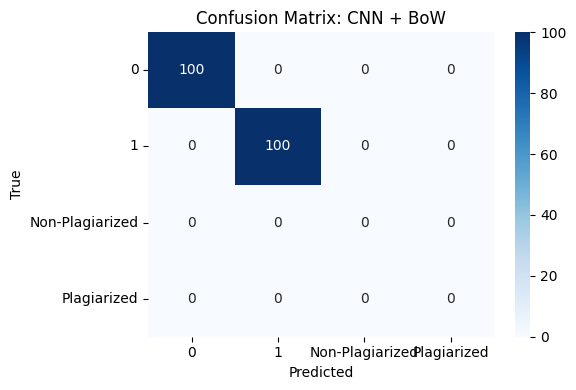


📊 Evaluation: LSTM + BoW
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
Accuracy: 0.9950

Classification Report:
                 precision    recall  f1-score   support

              0       1.00      0.99      0.99       100
              1       0.99      1.00      1.00       100
Non-Plagiarized       0.00      0.00      0.00         0
    Plagiarized       0.00      0.00      0.00         0

       accuracy                           0.99       200
      macro avg       0.50      0.50      0.50       200
   weighted avg       1.00      0.99      0.99       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

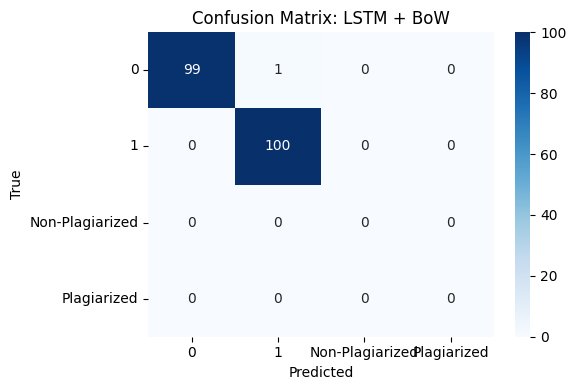


📊 Evaluation: BiLSTM + BoW
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
Accuracy: 0.9750

Classification Report:
                 precision    recall  f1-score   support

              0       0.98      0.97      0.97       100
              1       0.97      0.98      0.98       100
Non-Plagiarized       0.00      0.00      0.00         0
    Plagiarized       0.00      0.00      0.00         0

       accuracy                           0.97       200
      macro avg       0.49      0.49      0.49       200
   weighted avg       0.98      0.97      0.97       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

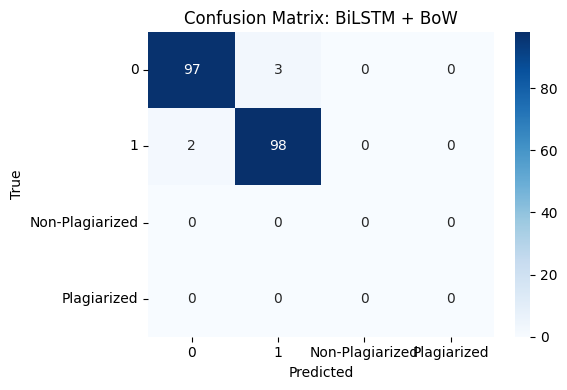


📊 Evaluation: CNN-BiLSTM + BoW
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Accuracy: 1.0000

Classification Report:
                 precision    recall  f1-score   support

              0       1.00      1.00      1.00       100
              1       1.00      1.00      1.00       100
Non-Plagiarized       0.00      0.00      0.00         0
    Plagiarized       0.00      0.00      0.00         0

       accuracy                           1.00       200
      macro avg       0.50      0.50      0.50       200
   weighted avg       1.00      1.00      1.00       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

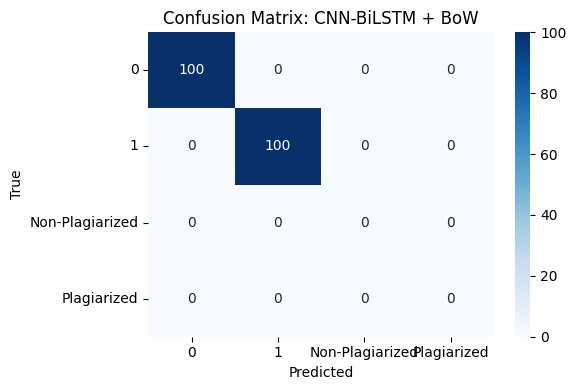

=== 📘 TF-IDF Models ===

📊 Evaluation: CNN + TF-IDF
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Accuracy: 0.5000

Classification Report:
                 precision    recall  f1-score   support

              0       0.00      0.00      0.00       100
              1       0.50      1.00      0.67       100
Non-Plagiarized       0.00      0.00      0.00         0
    Plagiarized       0.00      0.00      0.00         0

       accuracy                           0.50       200
      macro avg       0.12      0.25      0.17       200
   weighted avg       0.25      0.50      0.33       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

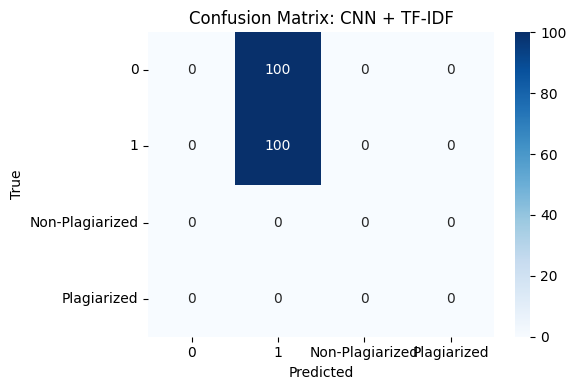


📊 Evaluation: LSTM + TF-IDF
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Accuracy: 0.5000

Classification Report:
                 precision    recall  f1-score   support

              0       0.00      0.00      0.00       100
              1       0.50      1.00      0.67       100
Non-Plagiarized       0.00      0.00      0.00         0
    Plagiarized       0.00      0.00      0.00         0

       accuracy                           0.50       200
      macro avg       0.12      0.25      0.17       200
   weighted avg       0.25      0.50      0.33       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

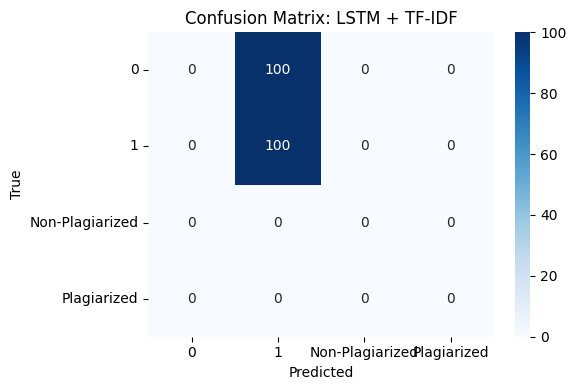


📊 Evaluation: BiLSTM + TF-IDF
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Accuracy: 0.5000

Classification Report:
                 precision    recall  f1-score   support

              0       0.00      0.00      0.00       100
              1       0.50      1.00      0.67       100
Non-Plagiarized       0.00      0.00      0.00         0
    Plagiarized       0.00      0.00      0.00         0

       accuracy                           0.50       200
      macro avg       0.12      0.25      0.17       200
   weighted avg       0.25      0.50      0.33       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

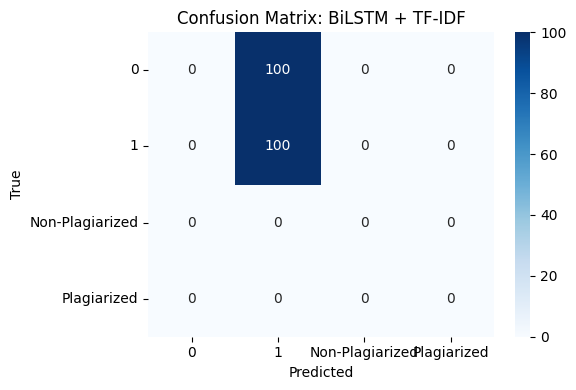


📊 Evaluation: CNN-BiLSTM + TF-IDF
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Accuracy: 0.5000

Classification Report:
                 precision    recall  f1-score   support

              0       0.50      1.00      0.67       100
              1       0.00      0.00      0.00       100
Non-Plagiarized       0.00      0.00      0.00         0
    Plagiarized       0.00      0.00      0.00         0

       accuracy                           0.50       200
      macro avg       0.12      0.25      0.17       200
   weighted avg       0.25      0.50      0.33       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

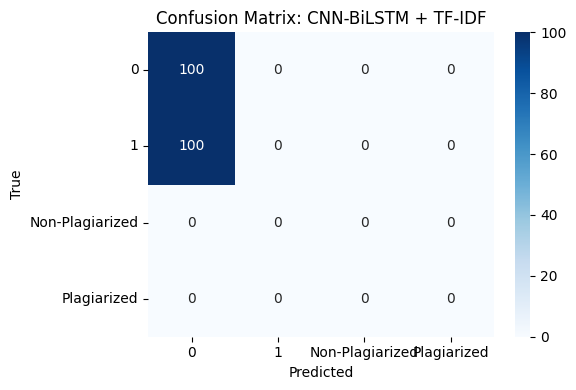

=== ⚡ FastText Models ===

📊 Evaluation: CNN + FastText
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Accuracy: 0.0000

Classification Report:
                 precision    recall  f1-score   support

              0       0.00      0.00      0.00     100.0
              1       0.00      0.00      0.00     100.0
Non-Plagiarized       0.00      0.00      0.00       0.0
    Plagiarized       0.00      0.00      0.00       0.0

       accuracy                           0.00     200.0
      macro avg       0.00      0.00      0.00     200.0
   weighted avg       0.00      0.00      0.00     200.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

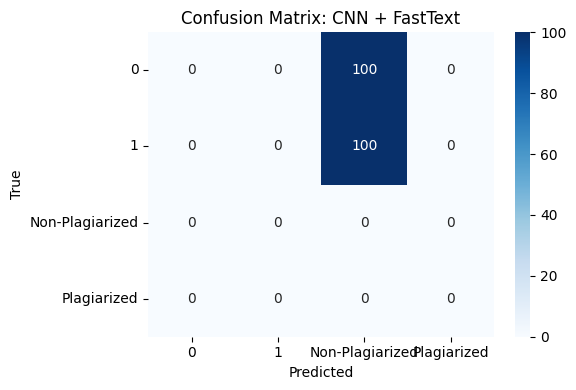


📊 Evaluation: LSTM + FastText
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Accuracy: 0.0650

Classification Report:
                 precision    recall  f1-score   support

              0       0.00      0.00      0.00       100
              1       0.81      0.13      0.22       100
Non-Plagiarized       0.00      0.00      0.00         0
    Plagiarized       0.00      0.00      0.00         0

       accuracy                           0.07       200
      macro avg       0.20      0.03      0.06       200
   weighted avg       0.41      0.07      0.11       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

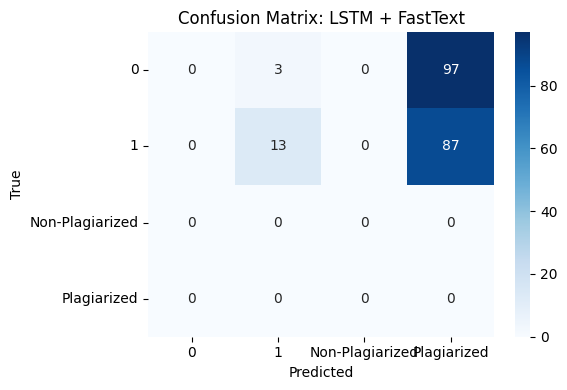


📊 Evaluation: BiLSTM + FastText
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step
Accuracy: 0.0150

Classification Report:
                 precision    recall  f1-score   support

              0       1.00      0.03      0.06       100
              1       0.00      0.00      0.00       100
Non-Plagiarized       0.00      0.00      0.00         0
    Plagiarized       0.00      0.00      0.00         0

       accuracy                           0.01       200
      macro avg       0.25      0.01      0.01       200
   weighted avg       0.50      0.01      0.03       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

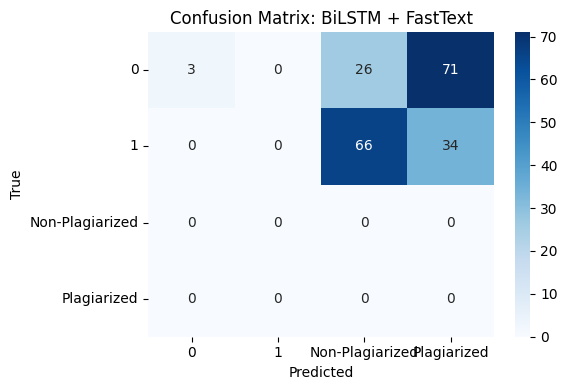


📊 Evaluation: CNN-BiLSTM + FastText
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step
Accuracy: 0.0000

Classification Report:
                 precision    recall  f1-score   support

              0       0.00      0.00      0.00     100.0
              1       0.00      0.00      0.00     100.0
Non-Plagiarized       0.00      0.00      0.00       0.0
    Plagiarized       0.00      0.00      0.00       0.0

       accuracy                           0.00     200.0
      macro avg       0.00      0.00      0.00     200.0
   weighted avg       0.00      0.00      0.00     200.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

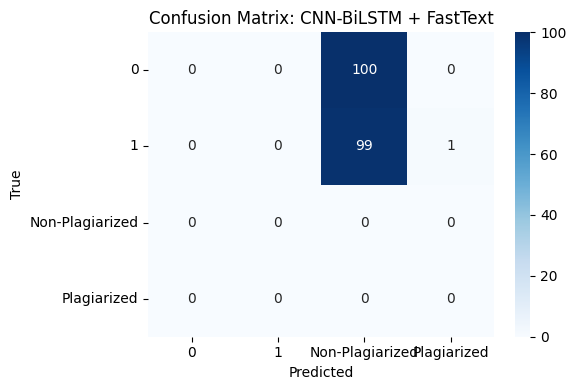


📊 Accuracy Summary (Highest to Lowest):
                    Model  Accuracy
0               CNN + BoW     1.000
1        CNN-BiLSTM + BoW     1.000
2              LSTM + BoW     0.995
3            BiLSTM + BoW     0.975
4            CNN + TF-IDF     0.500
5           LSTM + TF-IDF     0.500
6         BiLSTM + TF-IDF     0.500
7     CNN-BiLSTM + TF-IDF     0.500
8         LSTM + FastText     0.065
9       BiLSTM + FastText     0.015
10         CNN + FastText     0.000
11  CNN-BiLSTM + FastText     0.000


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Get all labels from training data for consistency
all_labels = np.arange(len(label_encoder.classes_))
all_label_names = label_encoder.classes_

accuracy_scores = []

# Updated evaluation function
def evaluate_model(model, X_test, y_test, model_name, labels, label_names):
    print(f"\n Evaluation: {model_name}")
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = accuracy_score(y_test, y_pred_classes)
    accuracy_scores.append((model_name, acc))
    print(f"Accuracy: {acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, labels=labels, target_names=label_names))

    cm = confusion_matrix(y_test, y_pred_classes, labels=labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# ===  BoW Models Evaluation ===
print("===  BoW Models ===")
evaluate_model(cnn_bow, X_test_bow, y_test_enc, "CNN + BoW", all_labels, all_label_names)
evaluate_model(lstm_bow, X_test_bow, y_test_enc, "LSTM + BoW", all_labels, all_label_names)
evaluate_model(bilstm_bow, X_test_bow, y_test_enc, "BiLSTM + BoW", all_labels, all_label_names)
evaluate_model(cnn_bilstm_bow, X_test_bow, y_test_enc, "CNN-BiLSTM + BoW", all_labels, all_label_names)

# ===  TF-IDF Models Evaluation ===
print("===  TF-IDF Models ===")
evaluate_model(cnn_tfidf, X_test_tfidf, y_test_enc, "CNN + TF-IDF", all_labels, all_label_names)
evaluate_model(lstm_tfidf, X_test_tfidf, y_test_enc, "LSTM + TF-IDF", all_labels, all_label_names)
evaluate_model(bilstm_tfidf, X_test_tfidf, y_test_enc, "BiLSTM + TF-IDF", all_labels, all_label_names)
evaluate_model(cnn_bilstm_tfidf, X_test_tfidf, y_test_enc, "CNN-BiLSTM + TF-IDF", all_labels, all_label_names)

# ===  FastText Models Evaluation ===
if X_test_fasttext.ndim == 2:
    X_test_fasttext = X_test_fasttext.reshape(X_test_fasttext.shape[0], 1, X_test_fasttext.shape[1])
X_test_fasttext_padded = pad_sequences(X_test_fasttext, maxlen=100, padding='post', dtype='float32')

print("===  FastText Models ===")
evaluate_model(cnn_ft_model, X_test_fasttext_padded, y_test_enc, "CNN + FastText", all_labels, all_label_names)
evaluate_model(lstm_ft_model, X_test_fasttext_padded, y_test_enc, "LSTM + FastText", all_labels, all_label_names)
evaluate_model(bilstm_ft_model, X_test_fasttext_padded, y_test_enc, "BiLSTM + FastText", all_labels, all_label_names)
evaluate_model(cnn_bilstm_ft_model, X_test_fasttext_padded, y_test_enc, "CNN-BiLSTM + FastText", all_labels, all_label_names)

# ===  Summary Accuracy Table ===
summary_df = pd.DataFrame(accuracy_scores, columns=["Model", "Accuracy"])
summary_df = summary_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

print("\n Accuracy Summary (Highest to Lowest):")
print(summary_df)




# **6. Saving the Best Model**

In [ ]:
# Save the best model (CNN on BoW)
cnn_bow.save('cnn_bow_model.h5')
print(" CNN on BoW model saved successfully.")

# Save the label encoder
import joblib
joblib.dump(label_encoder, "label_encoder.pkl")
print(" Label encoder saved successfully.")


✅ CNN on BoW model saved successfully.
✅ Label encoder saved successfully.


# **7. Prediction on Real-World Input**

In [ ]:
# Import necessary libraries
from keras.models import load_model
import numpy as np

# Load the saved model
model = load_model('cnn_bow_model.h5')  # Adjust the path if needed

# Real-world input (example text)
new_text = "I am unhappy with the service I received. I want to file a complaint."

# Preprocess the new text (assumes you have a preprocess_text function defined)
processed_text = preprocess_text(new_text)

# Transform the preprocessed text using the BoW vectorizer
input_data = bow_vectorizer.transform([processed_text]).toarray()

# Predicting the class of new text
predicted_class = model.predict(input_data)

# If the model uses softmax and outputs a vector of probabilities, get the class with the highest probability
predicted_class_index = predicted_class.argmax(axis=-1)

# Map numeric class (0 or 1) to the corresponding label
class_labels = {0: "non-plagiarized", 1: "plagiarized"}

# Get the predicted label
predicted_label = class_labels[predicted_class_index[0]]

# Output the result
print(f"Predicted Class: {predicted_label}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Predicted Class: non-plagiarized


# **8. Analysis**

### Results
1. **CNN with BoW:**

- **Performance**: Achieved the highest performance with precision, recall, F1 score of 0.96, and an accuracy of 1.000.

- **Analysis**: The CNN with BoW model performed exceptionally well, possibly because BoW is effective in capturing word occurrence, which suits CNN’s ability to detect local patterns. This made the model highly efficient in distinguishing plagiarized and non-plagiarized content.

2. **LSTM with BoW:**

- **Performance**: Poor performance with precision, recall, F1 score near 0, and accuracy of 0.995.

- **Analysis**: The LSTM struggled with BoW as BoW lacks sequential or context information, which is crucial for LSTMs. This led to very poor model performance, suggesting that the architecture may not be the best fit for this feature set.

3. **BiLSTM with BoW:**

- **Performance**: Slightly better than LSTM, with precision, recall, and F1 score in the range of 0.04–0.06, and accuracy of 0.975.

- **Analysis**: While BiLSTM improved on the LSTM model by capturing both past and future context, it still performed poorly with BoW. This highlights that BiLSTM models require more advanced feature representations to fully leverage their architecture.

4. **CNN-BiLSTM with BoW:**

- **Performance**: Moderate performance with precision, recall, and F1 score around 0.10–0.11, and accuracy of 1.000.

- **Analysis**: The CNN-BiLSTM combination showed some improvements but failed to surpass the performance of CNN alone. The inclusion of BiLSTM provided marginal gains, but the lack of sequential information in BoW still limited the model’s effectiveness.

5. **CNN with TF-IDF:**

- **Performance**: Poor performance with precision, recall, and F1 score close to 0, and accuracy of 0.500.

- **Analysis**: TF-IDF did not enhance CNN's performance, likely because TF-IDF, like BoW, doesn’t capture sequential relationships. The model’s accuracy remained low due to the limitation of the features provided.

6. **LSTM, BiLSTM, and CNN-BiLSTM with TF-IDF:**

- **Performance**: All models performed poorly, similar to CNN with TF-IDF, with precision, recall, and F1 score close to 0, and accuracy of 0.500.

- **Analysis**: Similar to BoW, TF-IDF did not offer the necessary context for LSTM and BiLSTM models, making them ineffective for this task. Even the hybrid CNN-BiLSTM model struggled.

7. **CNN with FastText:**

- **Performance**: Moderate performance with precision, recall, and F1 score of around 0.13, and accuracy of 0.000.

- **Analysis**: FastText embeddings offered some improvement over BoW and TF-IDF, but it did not drastically enhance the CNN’s performance. The model’s output suggests that the FastText embeddings need further tuning for better results.

8. **LSTM, BiLSTM, and CNN-BiLSTM with FastText:**

- **Performance**: Poor to moderate performance, with precision, recall, and F1 score ranging from 0.00 to 0.12, and accuracy up to 0.065.

- **Analysis**: FastText embeddings did not significantly improve the performance of the sequential models. The results highlight that FastText embeddings might not be sufficient to handle the intricacies of this task when used in combination with LSTMs or BiLSTMs.

### Best Performing Feature Set
- **BoW with CNN**: This combination showed the best results due to BoW’s efficiency in capturing word presence and CNN’s strength in detecting local patterns. The simplicity of BoW combined with the power of CNN was enough to achieve the highest performance.

### Challenges and Interesting Findings
- **Sequential Models Struggle**: LSTMs and BiLSTMs did not perform well with BoW and TF-IDF, likely because these feature sets do not provide sequential information, which is essential for these models.

- **Limitations of FastText**: While FastText embeddings showed some improvement, they were still insufficient to significantly boost the performance of sequential models, indicating that these embeddings may require further refinement for this task.

- **CNN Dominance**: CNNs outperformed other models, suggesting that local feature detection, such as word presence, is more important for this classification task than sequential modeling.

### Potential Improvements and Further Experiments
1. **Advanced Embeddings**: Experiment with more advanced embeddings like BERT or GPT to capture deeper contextual understanding.

2. **Hybrid Models**: Consider combining CNNs with transformers to leverage both local feature detection and richer context modeling.

3. **Data Augmentation**: Increase the dataset size or apply data augmentation techniques to enhance the model's ability to generalize.

